In [1]:
import pandas as pd

col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
             "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
             "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
             "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
             "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
             "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
             "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
             "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "attack", "last_flag"]

train_df = pd.read_csv("data/Train.csv", names=col_names)
test_df = pd.read_csv("data/Test.csv", names=col_names)

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

train_df['target'] = train_df['attack'].apply(lambda x: 0 if x == 'normal' else 1)
test_df['target'] = test_df['attack'].apply(lambda x: 0 if x == 'normal' else 1)

for col in ['protocol_type', 'service', 'flag']:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

train_df.drop(['attack', 'last_flag'], axis=1, inplace=True)
test_df.drop(['attack', 'last_flag'], axis=1, inplace=True)

X_train_full = train_df.drop('target', axis=1)
y_train_full = train_df['target']

X_train_norm = X_train_full[y_train_full == 0]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_norm)

X_test = test_df.drop('target', axis=1)
y_test = test_df['target'].values
X_test_scaled = scaler.transform(X_test)


In [3]:
X_train_seq = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_seq = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

input_dim = X_train_seq.shape[2]
inputs = Input(shape=(1, input_dim))

# DEEP ENCODER: LSTM(128) → LSTM(64)
x = LSTM(128, activation='relu', return_sequences=True)(inputs)
x = LSTM(64, activation='relu', return_sequences=False)(x)

# Bottleneck
x = RepeatVector(1)(x)

# DEEP DECODER: LSTM(64) → LSTM(128)
x = LSTM(64, activation='relu', return_sequences=True)(x)
x = LSTM(128, activation='relu', return_sequences=True)(x)

# Output
outputs = TimeDistributed(Dense(input_dim))(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

2025-05-14 17:05:03.717158: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-14 17:05:03.717192: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-14 17:05:03.717197: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1747235103.717418   46070 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1747235103.717718   46070 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 41)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 128)         │        87,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1, 41)          │         5,289 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,577 (1.04 MB)

 Trainable params: 273,577 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_seq, X_train_seq,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.1,
                    shuffle=True,
                    callbacks=[early_stop])

Epoch 1/50


2025-05-14 17:05:21.197153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


474/474 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - loss: 0.7070 - val_loss: 0.1880
Epoch 2/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 0.2438 - val_loss: 0.0958
Epoch 3/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 0.1722 - val_loss: 0.0484
Epoch 4/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 0.0584 - val_loss: 0.0667
Epoch 5/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 0.1080 - val_loss: 0.0380
Epoch 6/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 0.1359 - val_loss: 0.0294
Epoch 7/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 0.0477 - val_loss: 0.0370
Epoch 8/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 0.0366 - val_loss: 0.0347
Epoch 9/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 0.1141 - val_loss: 0.0244
Epoch 10/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - loss: 0.0455 - val_loss: 0.0286
Epoch 11/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.0305 - val_loss: 0.0204
Epoch 12/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 

In [6]:
import numpy as np

X_pred_train = model.predict(X_train_seq)
mse_train = np.mean(np.mean(np.square(X_train_seq - X_pred_train), axis=2), axis=1)

threshold = np.percentile(mse_train, 95)
print(f"Threshold (95th percentile): {threshold:.4f}")

2105/2105 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step
Threshold (95th percentile): 0.0234


In [7]:
X_pred_test = model.predict(X_test_seq)
mse_test = np.mean(np.mean(np.square(X_test_seq - X_pred_test), axis=2), axis=1)

y_pred = (mse_test > threshold).astype(int)

705/705 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


In [8]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Confusion Matrix:
[[ 9263   448]
 [ 2352 10481]]

Classification Report:
              precision    recall  f1-score   support

           0     0.7975    0.9539    0.8687      9711
           1     0.9590    0.8167    0.8822     12833

    accuracy                         0.8758     22544
   macro avg     0.8783    0.8853    0.8754     22544
weighted avg     0.8894    0.8758    0.8764     22544



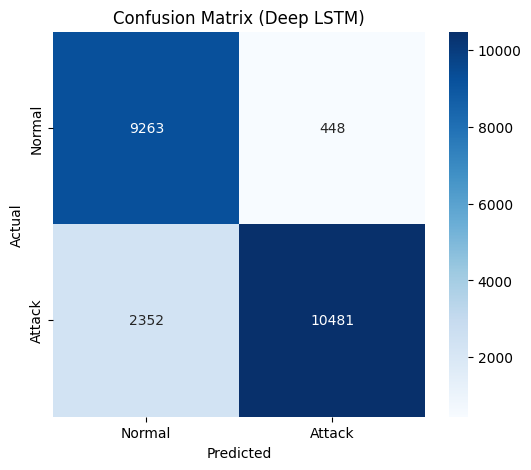

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Deep LSTM)")
plt.show()

ROC AUC Score: 0.9589


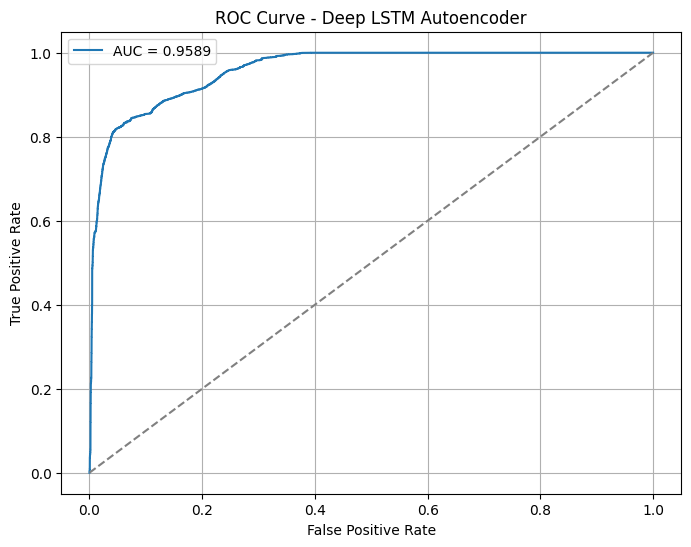

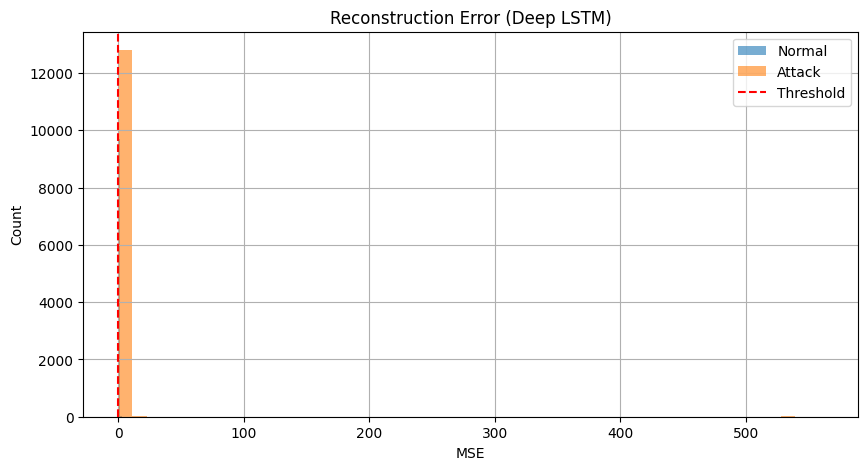

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve

roc_auc = roc_auc_score(y_test, mse_test)
print(f"ROC AUC Score: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, mse_test)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Deep LSTM Autoencoder")
plt.legend()
plt.grid()
plt.show()

# Histogram of MSE
plt.figure(figsize=(10, 5))
plt.hist(mse_test[y_test == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(mse_test[y_test == 1], bins=50, alpha=0.6, label='Attack')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Reconstruction Error (Deep LSTM)")
plt.xlabel("MSE")
plt.ylabel("Count")
plt.legend()
plt.grid()
plt.show()